In [1]:
import glob
import math
import pathlib

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
import tensorflow as tf
from tensorflow import keras

# set random seed for reproductibility
random_seed = 0
np.random.seed(random_seed)

try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-25 14:50:52.064822: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-bc7789c2-d296-5031-05db-2e9119e70ea3)


# DataGenerator

In [6]:
class CustomDataGenerator(keras.utils.Sequence):
    # We use Sequence as parent class, because Sequence are a safer way to do multiprocessing.
    # This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.
    
    def __init__(self, datapath, batch_size, augmentation=None, preprocessing=None, shuffle=False, verbose=0, maxbatches=None, *args, **kwargs):
        self.batch_size = batch_size
        self.ids = [x[:-4] for x in glob.glob(f"{datapath}/*[!_labels].png")]
        self.shuffle = shuffle
        self.verbose = verbose
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.maxbatches = maxbatches
        #print(len(self.ids), self.ids)
        
    def __len__(self):
        # returns the number of batches
        if self.maxbatches:
            return min(self.maxbatches, math.ceil(len(self.ids) / self.batch_size))
        else:
            return math.ceil(len(self.ids) / self.batch_size)
    
    def __getitem__(self, index):
        # returns one batch
        
        since = index * self.batch_size
        until = (index+1) * self.batch_size
        batch_ids = self.ids[since:until]
        
        images = []
        labels = []
        for source_id in batch_ids:
            if self.verbose > 0:
                print(source_id)
            
            x = np.array(Image.open(f"{source_id}.png"))            
            y = np.array(Image.open(f"{source_id}_labels.png"))
            
            if self.augmentation:
                augmented = self.augmentation(image=x, mask=y)
                x, y = augmented['image'], augmented['mask']
                
            if self.preprocessing:
                x = self.preprocessing(x)
              
            images.append(x/255.0) # normalize between 0 and 1 at the same time
            #labels.append(y)
            labels.append(keras.utils.to_categorical(y, 8))
         
        return np.array(images, dtype=float), np.array(labels, dtype=float)
        
    def on_epoch_end(self):
        # logics run once at the very beginning and then at the end of each epoch
        if self.shuffle:
            return np.random.shuffle(self.ids) # /!\ Is this really a good idea ????

## Tests **sans** data-augmentation

In [7]:
batch_size = 4
datapath = pathlib.Path('data','preprocessed','256x128', 'train')
datagen = CustomDataGenerator(datapath, batch_size, shuffle=False, verbose=1)
print("len:", len(datagen))

len: 744


In [8]:
datagen.on_epoch_end()
one_batch_x, one_batch_y = datagen[101]
print(one_batch_x.shape, one_batch_y.shape)

data/preprocessed/256x128/train/dusseldorf_000149_000019
data/preprocessed/256x128/train/dusseldorf_000089_000019
data/preprocessed/256x128/train/strasbourg_000001_018155
data/preprocessed/256x128/train/ulm_000023_000019
(4, 128, 256, 3) (4, 128, 256, 8)


(128, 256, 3)
(128, 256, 3)
(128, 256, 3)
(128, 256, 3)


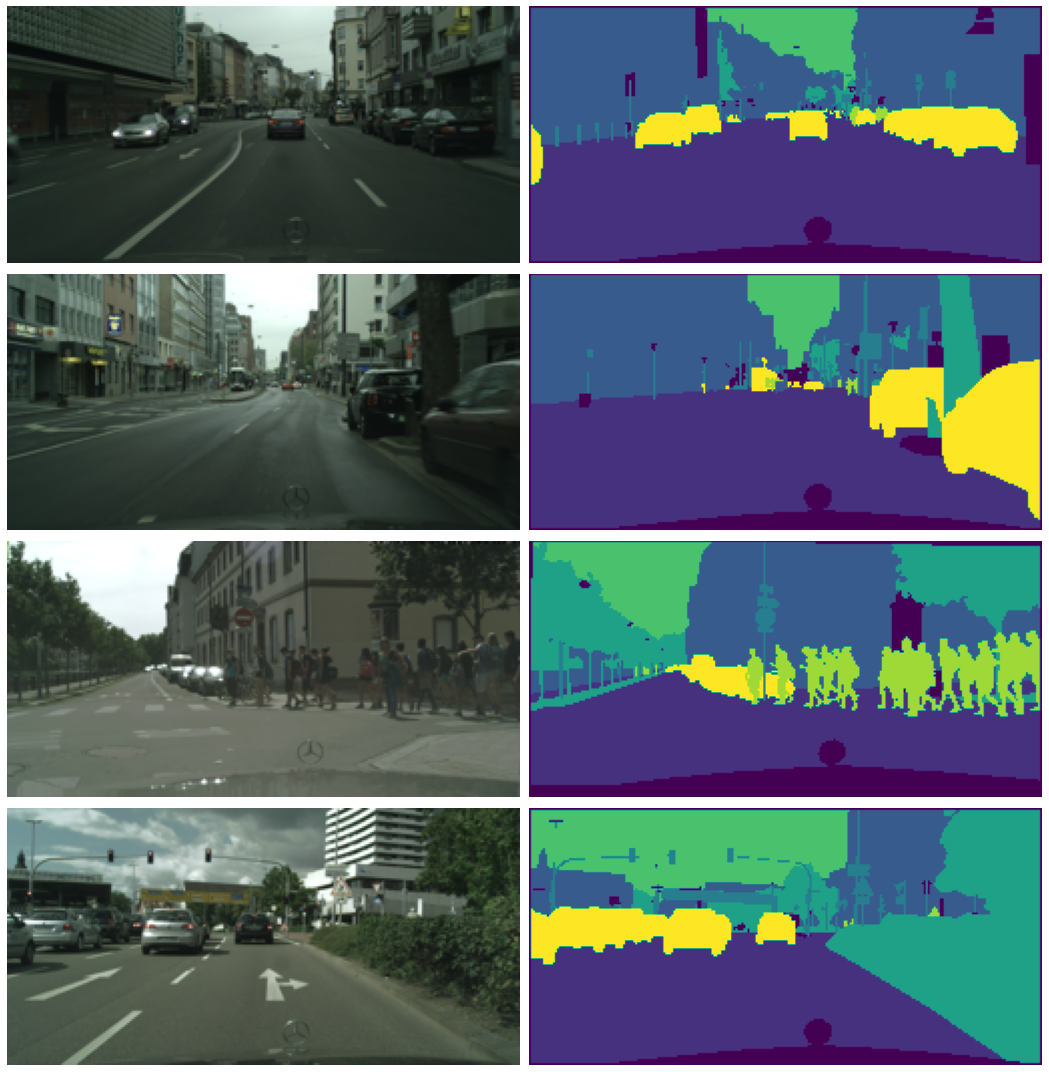

In [9]:
fig = plt.figure(figsize=(15,15))
for i, (img, mask) in enumerate(zip(one_batch_x,one_batch_y)):
    ax = plt.subplot(batch_size, 2, (i*2)+1)
    print(img.shape)
    plt.imshow(img)
    ax.axis('off')
    
    ax = plt.subplot(batch_size, 2, (i*2)+2)
    mmask = np.argmax(mask, axis=2)
    plt.imshow(mmask)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Tests **avec** data-augmentation

>L'augmentation des données est une stratégie qui permet d'accroître de manière significative la diversité des données disponibles pour l'entraînement des modèles (sans collecter de nouvelles données).
>
>Cette technique permet de rendre le modèle plus robuste et d'éviter l'overfitting.
>
> En 2018, Google a publié un article sur AutoAugment (un algorithme qui découvre automatiquement le meilleur ensemble d'augmentations pour le jeu de données). Ils ont montré qu'un ensemble personnalisé d'augmentations améliore les performances du modèle.

In [10]:
transform1 = A.Compose([
    # A.RandomCrop(width=100, height=100),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.RandomRotate90(p=0.5),
    A.Rotate(15, p=0.5),
    # A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.01, blur_limit = 3),
    # A.OneOf([
    #        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    #        A.GridDistortion(p=0.5),
    #        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    # ], p=0.5)
])

In [11]:
batch_size = 4
datapath = pathlib.Path('data','preprocessed','256x128', 'train')
datagen = CustomDataGenerator(datapath, batch_size, augmentation=transform1, shuffle=False, verbose=1) # on garde shuffle=False pour afficher les même images
print("len:", len(datagen))

len: 744


In [12]:
datagen.on_epoch_end()
one_batch_x, one_batch_y = datagen[101]
print(one_batch_x.shape, one_batch_y.shape)

data/preprocessed/256x128/train/dusseldorf_000149_000019
data/preprocessed/256x128/train/dusseldorf_000089_000019
data/preprocessed/256x128/train/strasbourg_000001_018155
data/preprocessed/256x128/train/ulm_000023_000019
(4, 128, 256, 3) (4, 128, 256, 8)


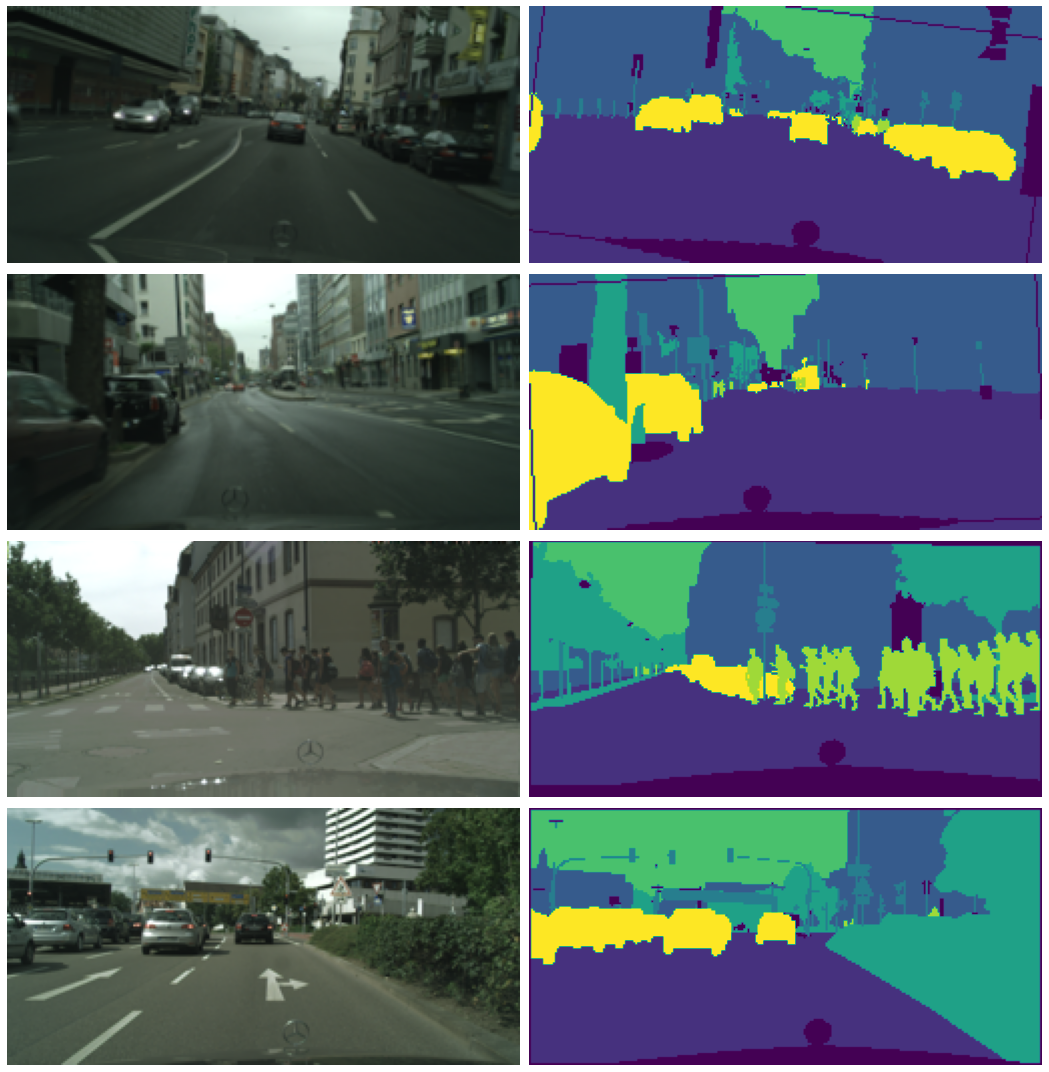

In [13]:
fig = plt.figure(figsize=(15,15))
for i, (img, mask) in enumerate(zip(one_batch_x,one_batch_y)):
    ax = plt.subplot(batch_size, 2, (i*2)+1)
    plt.imshow(img)
    ax.axis('off')
    
    ax = plt.subplot(batch_size, 2, (i*2)+2)
    mmask = np.argmax(mask, axis=2)
    plt.imshow(mmask)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Tests avec un préprocessing passé en paramètre

In [15]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


### Définissons un pré-processing

In [16]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

### Préparons les training et validation sets avec notre CustomDataGenerator

In [23]:
batch_size = 4

train_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'train'), 
    batch_size, 
    augmentation=transform1, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

valid_ds = CustomDataGenerator(
    pathlib.Path('data','preprocessed','256x128', 'val'), 
    batch_size, 
    augmentation=None, 
    preprocessing=preprocess_input, 
    shuffle=True,
    verbose=0,
    #maxbatches=100,
)

### Définissons et entrainons un modèle

In [24]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# f_loss = sm.losses.bce_jaccard_loss

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
model.compile(
    optimizer=f_opti,
    loss=f_loss, # sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [25]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    batch_size=batch_size,
    # callbacks=[es, checkpoint]
    # validation_split=0.2
)

Epoch 1/5
744/744 [==============================] - 49s 61ms/step - loss: 0.6011 - iou_score: 0.3987 - val_loss: 0.9539 - val_iou_score: 0.2590
Epoch 2/5
744/744 [==============================] - 43s 58ms/step - loss: 0.4504 - iou_score: 0.4841 - val_loss: 0.4258 - val_iou_score: 0.5046
Epoch 3/5
744/744 [==============================] - 44s 59ms/step - loss: 0.4132 - iou_score: 0.5131 - val_loss: 0.4017 - val_iou_score: 0.5253
Epoch 4/5
744/744 [==============================] - 45s 60ms/step - loss: 0.3925 - iou_score: 0.5297 - val_loss: 0.4197 - val_iou_score: 0.5337
Epoch 5/5
744/744 [==============================] - 45s 60ms/step - loss: 0.3739 - iou_score: 0.5424 - val_loss: 0.3729 - val_iou_score: 0.5449


In [26]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title(f_loss.name.title())
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot metric
    plt.subplot(212)
    plt.title('IoU scores')
    plt.plot(history.history['iou_score'], color='blue', label='train')
    plt.plot(history.history['val_iou_score'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

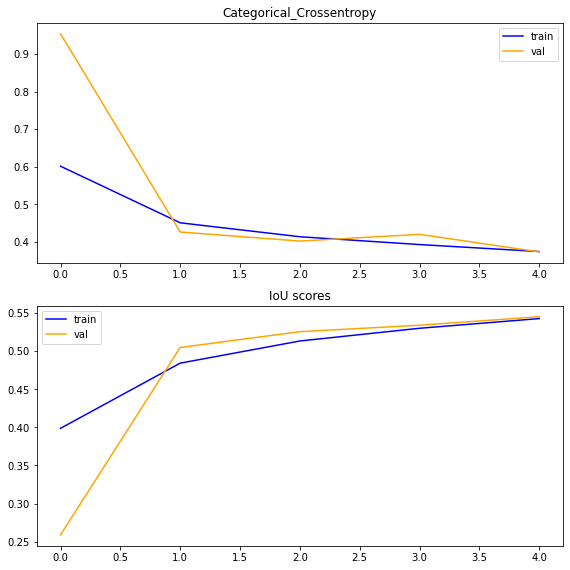

In [27]:
summarize_diagnostics(history)